# Test plane-based registration
Test different plane-based registration methods

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import get_correspondences, extract_corresponding_features
from planeslam.geometry.util import quat_to_rot_mat

%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True)

### Load AirSim data

In [15]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

In [16]:
# Extract scans
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

### Decoupled

In [17]:
from planeslam.registration import decoupled_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = decoupled_register(scans[i+1], scans[i])
    avg_runtime += time.time() - start_time
    print(t_hat)
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

[[ 0.14497635]
 [-1.19585232]
 [ 1.23233305]]
[[-0.009191  ]
 [-2.52738824]
 [-1.79024574]]
[[-0.04968349]
 [-3.96158334]
 [-0.35020581]]
[[ 0.07913207]
 [-4.28462333]
 [-0.36805397]]
[[-0.00431424]
 [-4.27786121]
 [-0.08658879]]
[[-0.26258462]
 [-3.90487242]
 [-0.13504622]]
[[ 0.22214625]
 [-4.42489485]
 [-0.05538656]]
[[-0.00723413]
 [-4.88605856]
 [-0.06641226]]
[[ 0.01852842]
 [-3.84844831]
 [-0.00602313]]
[[-0.05195909]
 [-4.39408373]
 [-0.10790757]]
[[ 0.07059074]
 [-4.49969582]
 [ 0.02493389]]
[[ 0.03843188]
 [-4.32395508]
 [-0.03132654]]
[[-0.00581487]
 [-4.32327865]
 [-0.058571  ]]
[[-0.01511899]
 [-4.42720059]
 [-0.04802296]]
[[0.]
 [0.]
 [0.]]
[[-2.55330505]
 [-2.30044185]
 [-0.73840521]]
[[-3.6066075 ]
 [ 0.31113987]
 [-0.05197913]]
[[-3.98551429]
 [ 1.22987338]
 [-0.17659265]]
[[-4.22028267]
 [ 0.9363781 ]
 [-0.23909822]]
[[-4.3139801 ]
 [-1.97337272]
 [-0.3618971 ]]
[[-4.65234311]
 [ 1.43354145]
 [-0.1009428 ]]
[[-4.4184418 ]
 [-0.23338686]
 [-0.03953195]]
[[-4.4472641 ]


In [18]:
np.round(abs_traj_transformations[:,:3,3],2)

array([[   0.14,   -1.2 ,    1.23],
       [   0.14,   -3.5 ,   -0.38],
       [   0.09,   -7.48,   -0.48],
       [   0.17,  -11.77,   -0.73],
       [   0.15,  -16.06,   -0.75],
       [  -0.19,  -19.96,   -0.84],
       [   0.09,  -24.39,   -0.9 ],
       [   0.07,  -29.27,   -0.97],
       [   0.15,  -33.12,   -0.97],
       [   0.13,  -37.52,   -1.1 ],
       [   0.11,  -42.02,   -0.75],
       [   0.05,  -46.34,   -1.1 ],
       [  -0.1 ,  -50.66,   -1.19],
       [   0.07,  -55.09,   -1.28],
       [   0.07,  -55.09,   -1.28],
       [  -6.9 ,  -57.2 ,   -2.65],
       [ -11.53,  -55.04,  -14.19],
       [ -15.52,  -50.75,  -23.17],
       [ -20.  ,  -49.15,  -24.64],
       [ -24.6 ,  -52.57,  -21.62],
       [ -29.04,  -52.41,  -18.6 ],
       [ -33.53,  -52.83,  -18.  ],
       [ -38.  ,  -52.54,  -18.95],
       [ -42.54,  -52.01,  -19.99],
       [ -47.03,  -51.8 ,  -20.24],
       [ -51.42,  -52.01,  -19.99],
       [  -1.31,  -33.64,   67.58],
       [  -8.53,  -44.05,   

### Gauss-newton

In [19]:
from planeslam.registration import GN_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = GN_register(scans[i+1], scans[i])
    avg_runtime += time.time() - start_time
    print(t_hat)
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

final loss:  83.94139681886668
[[-1.77978397]
 [ 3.78587628]
 [ 1.13993601]]
final loss:  296.08740057370056
[[-5.99483767]
 [-0.99286459]
 [-0.62273275]]
final loss:  532.6060383238397
[[-1.99583813]
 [ 7.00108123]
 [-8.3822632 ]]
final loss:  354.0010061519799
[[-1.94067019]
 [-7.37659953]
 [-3.45620138]]
final loss:  538.2522741659651
[[ 1.35798891]
 [-2.30654432]
 [-7.62343634]]
final loss:  1037.4145870989812
[[-1.76293648]
 [13.53722848]
 [-7.29668454]]
final loss:  1144.2592388623743
[[-7.22675596]
 [-3.18718976]
 [12.56364593]]
final loss:  731.8009446799133
[[-3.62711486]
 [-4.95079261]
 [ 9.08516534]]
final loss:  118.50585679199142
[[ 1.72213309]
 [-0.76670506]
 [ 3.86401278]]
final loss:  48.00569524683933
[[ 0.63156699]
 [ 4.0360315 ]
 [-0.27497872]]
final loss:  104.58491778998065
[[3.46421563]
 [5.55615645]
 [0.72919973]]
final loss:  349.1179725399021
[[ 4.65163556]
 [ 1.56955063]
 [-7.80628289]]
final loss:  75.30373642627441
[[ 5.27973919]
 [ 0.60496916]
 [-0.22839453

### Torch GN

In [27]:
# Set torch device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [28]:
from planeslam.registration import torch_GN_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = torch_GN_register(scans[i+1], scans[i], device)
    avg_runtime += time.time() - start_time
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

final loss:  tensor(0.1372, device='cuda:0')
final loss:  tensor(0.3257, device='cuda:0')
final loss:  tensor(0.0793, device='cuda:0')
final loss:  tensor(0.0510, device='cuda:0')
final loss:  tensor(0.1041, device='cuda:0')
final loss:  tensor(0.8607, device='cuda:0')
final loss:  tensor(0.8003, device='cuda:0')
final loss:  tensor(0.0067, device='cuda:0')
final loss:  tensor(0.0578, device='cuda:0')
final loss:  tensor(0.0148, device='cuda:0')
final loss:  tensor(0.0077, device='cuda:0')
final loss:  tensor(0.0195, device='cuda:0')
final loss:  tensor(0.1026, device='cuda:0')
final loss:  tensor(0.0837, device='cuda:0')
final loss:  tensor(0.2081, device='cuda:0')
final loss:  tensor(0.0701, device='cuda:0')
final loss:  tensor(0.2650, device='cuda:0')
final loss:  tensor(0.0149, device='cuda:0')
final loss:  tensor(0.0039, device='cuda:0')
final loss:  tensor(0.3659, device='cuda:0')
final loss:  tensor(0.0005, device='cuda:0')
final loss:  tensor(0.0002, device='cuda:0')
final loss

In [29]:
abs_traj_transformations[:,:3,3]

array([[   0.14263217,   -1.19524229,    1.23095465],
       [   0.12071719,   -3.90797426,   -0.76945062],
       [   0.08096314,   -7.79888515,   -1.42997786],
       [   0.15537396,  -12.05456425,   -1.9096809 ],
       [   0.17735579,  -16.31862872,   -2.04930531],
       [  -0.00627892,  -20.20674715,   -2.2443925 ],
       [   0.16225584,  -24.62331715,   -2.29301192],
       [   0.16525459,  -29.50493691,   -2.3524623 ],
       [   0.11304642,  -33.34971717,   -2.35933385],
       [   0.01882139,  -37.74174392,   -2.44045135],
       [   0.18922688,  -42.21322006,   -2.7847925 ],
       [   0.32627433,  -46.55288892,   -2.46410317],
       [   0.4578678 ,  -50.87385735,   -2.48092563],
       [   0.25770107,  -55.30125344,   -2.4864624 ],
       [   0.25770107,  -55.30125344,   -2.4864624 ],
       [   2.15208264,  -57.44474843,   -1.53692622],
       [  -0.96569633,  -56.17178853,   10.44249433],
       [  -4.84622773,  -52.48413116,   19.27131906],
       [  -9.36153544,  -50.

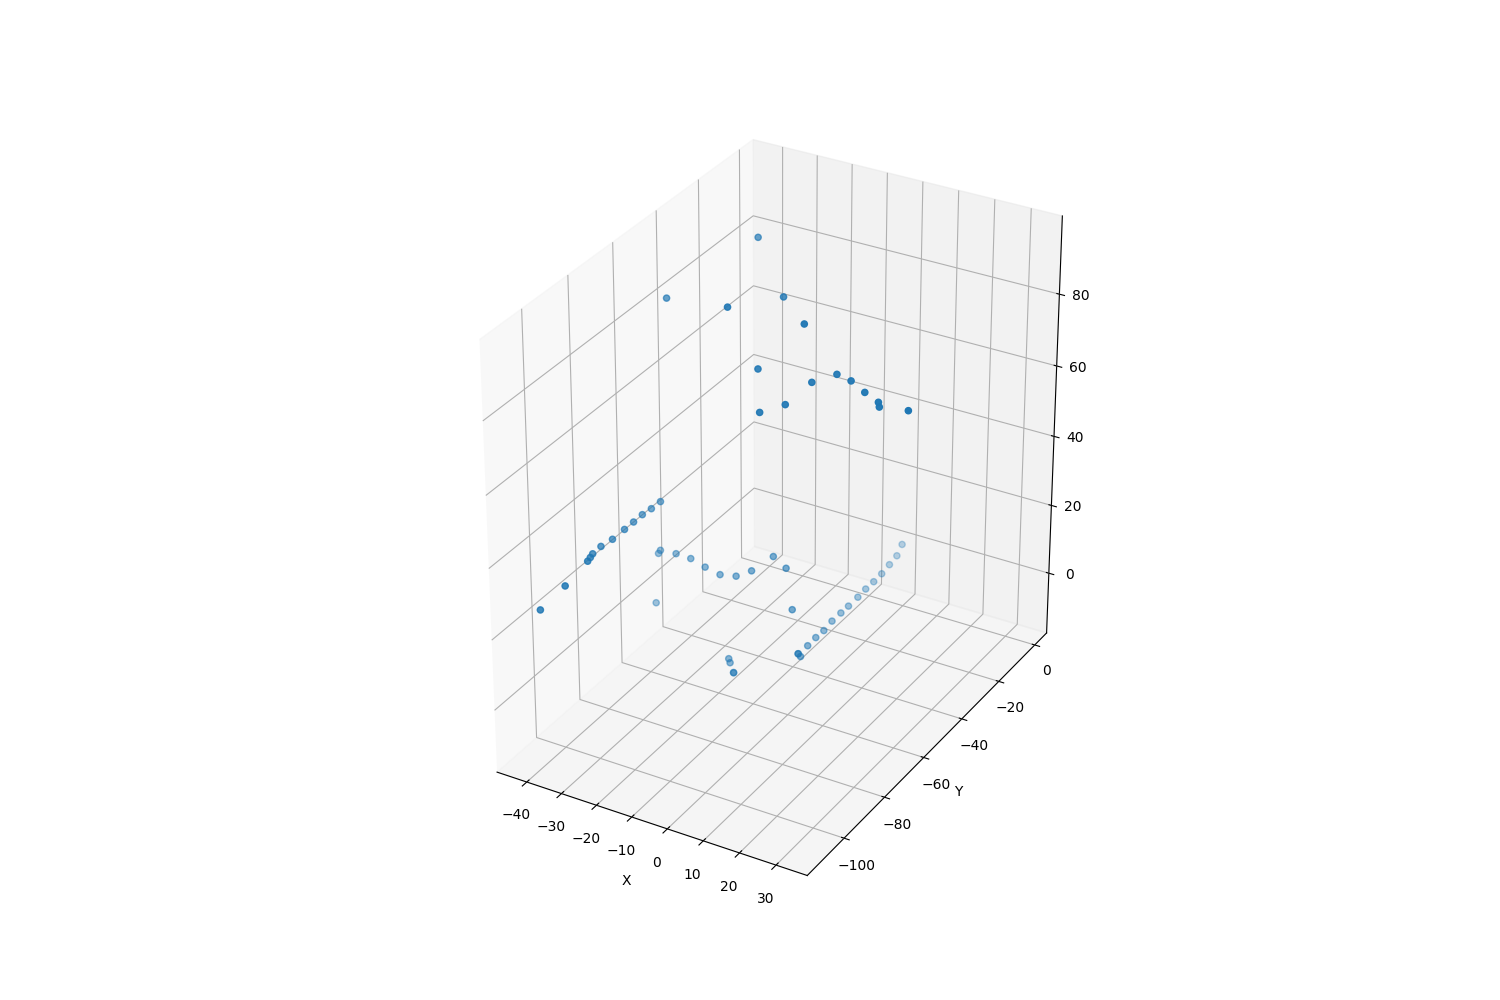

In [33]:
traj = abs_traj_transformations[:,:3,3]
ax = plot_3D_setup(traj)
ax.scatter(traj[:,0], traj[:,1], traj[:,2])

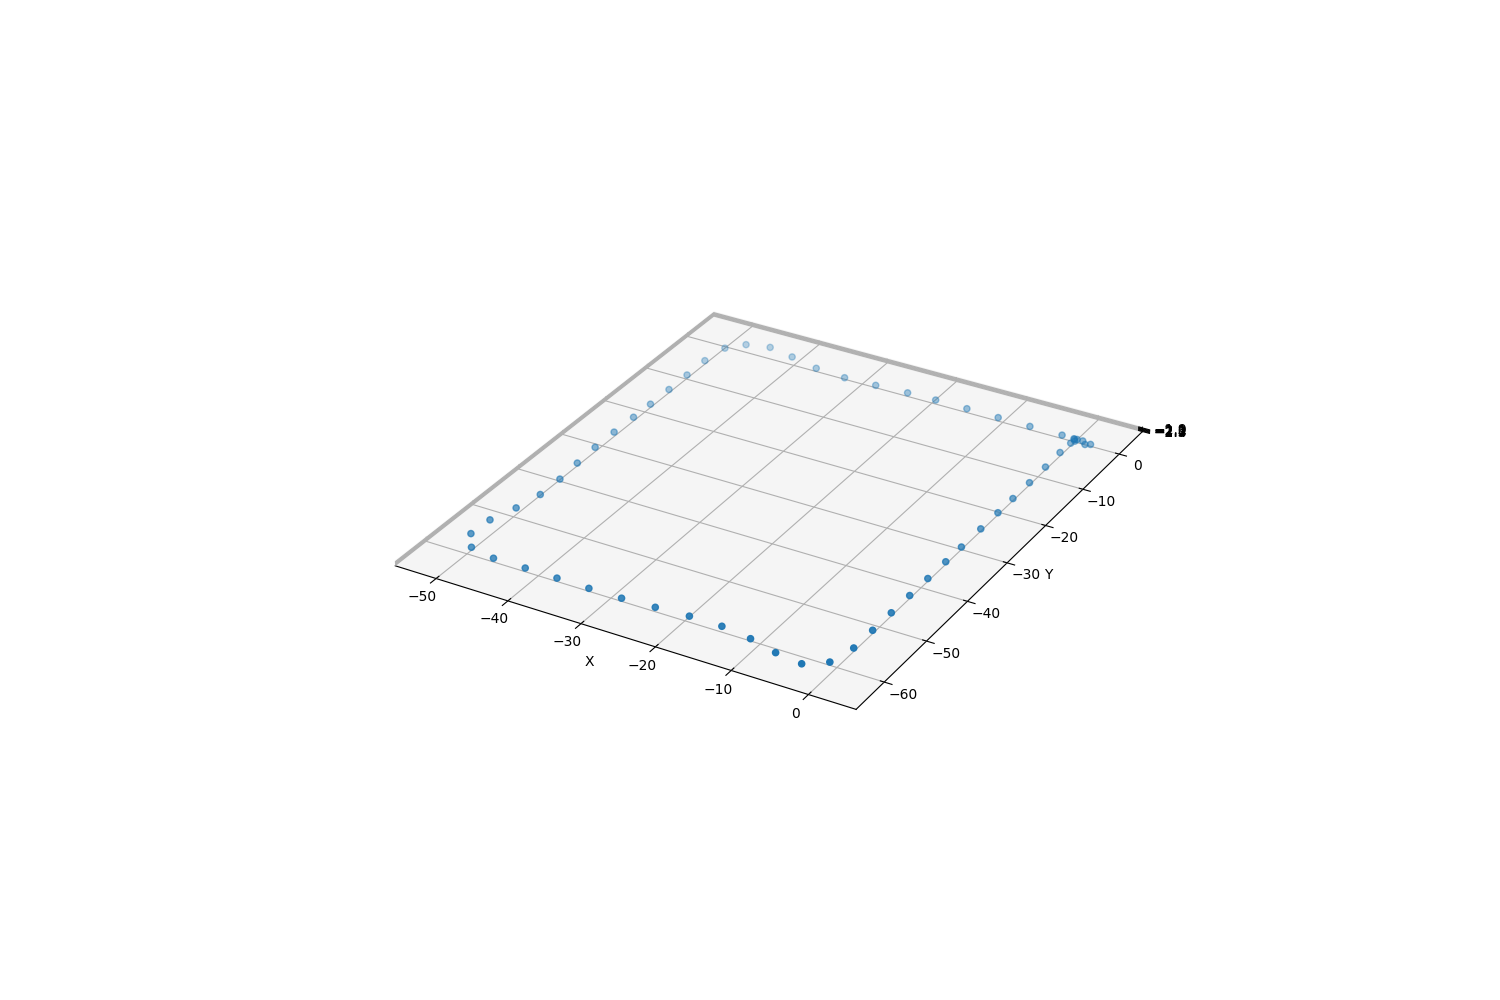

In [32]:
ax = plot_3D_setup(drone_positions)
ax.scatter(drone_positions[:,0], drone_positions[:,1], drone_positions[:,2])

In [12]:
filepath = os.path.join(os.getcwd(), '..', '..', 'data', 'results', 'l2l_abs_traj_transformations')
np.save(filepath, np.array(abs_traj_transformations))

### Torch SGD

In [24]:
from planeslam.registration import torch_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = torch_register(scans[i+1], scans[i], device)
    avg_runtime += time.time() - start_time
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

Final loss:  0.13801603  iterations:  250
Final loss:  0.4578731  iterations:  250
Final loss:  177.53824  iterations:  250
Final loss:  2.525107  iterations:  250
Final loss:  591.5755  iterations:  250
Final loss:  0.88698924  iterations:  250
Final loss:  0.8003002  iterations:  250
Final loss:  0.014691535  iterations:  250
Final loss:  0.07711908  iterations:  250
Final loss:  0.014747701  iterations:  250
Final loss:  0.007889938  iterations:  250
Final loss:  33.845844  iterations:  250
Final loss:  0.10258546  iterations:  250
Final loss:  42.041172  iterations:  250
Final loss:  0.0  iterations:  0
Final loss:  0.38239098  iterations:  250
Final loss:  0.13556498  iterations:  250
Final loss:  24.590273  iterations:  250
Final loss:  0.01697494  iterations:  250
Final loss:  13.923896  iterations:  250
Final loss:  0.36903933  iterations:  250
Final loss:  0.0007504435  iterations:  98
Final loss:  0.00081556465  iterations:  86
Final loss:  8.152626  iterations:  250
Final lo

In [25]:
abs_traj_transformations[:,:3,3]

array([[  0.14308596,  -1.19276011,   1.23307407],
       [  0.14409423,  -3.97959604,  -0.14546241],
       [ -0.81674314,  -4.71728243,  -0.03642718],
       [ -0.35261453,  -9.09915566,   0.53653076],
       [ -7.94997853,  -2.68426742,   0.63197294],
       [ -8.27178114,  -6.47454207,   0.23844217],
       [ -8.03008519, -10.89236788,   0.19856209],
       [ -8.01123975, -15.80917822,   0.01313321],
       [ -7.94135522, -19.71742222,   0.13643714],
       [ -7.98143079, -24.11402223,   0.03680189],
       [ -7.91697913, -28.61329825,   0.06301164],
       [-20.08150643, -21.21912577,   0.33282099],
       [-20.09879907, -25.55085998,   0.31719511],
       [-30.44004858, -11.79280361,   4.79222767],
       [-30.44004858, -11.79280361,   4.79222767],
       [-34.35243498, -11.48350325,   2.80995253],
       [-36.56470157, -14.15309738,   6.02545872],
       [-39.71425124,   6.42421948,   4.32294437],
       [-43.9085286 ,   7.50782913,   4.31922582],
       [-20.74016544,  31.21722

In [23]:
drone_positions

array([[  0.        ,   0.        ,  -2.31653404],
       [  0.        ,  -1.15521872,  -2.04235554],
       [  0.        ,  -4.08452988,  -1.93596601],
       [  0.        ,  -8.03334332,  -2.04300451],
       [  0.00000005, -12.31232262,  -2.11715913],
       [  0.00000007, -16.69724464,  -2.13905597],
       [  0.00000006, -20.6247654 ,  -2.13519597],
       [  0.00000006, -25.05467224,  -2.11951256],
       [  0.00000006, -29.98171997,  -2.09658241],
       [  0.00000008, -33.92455292,  -2.07667994],
       [  0.00000011, -38.36142731,  -2.05366993],
       [  0.00000008, -42.79831696,  -2.0304122 ],
       [  0.00000006, -47.235672  ,  -2.00705147],
       [  0.00000005, -51.67374039,  -1.98365676],
       [  0.00000005, -56.11180496,  -1.96023512],
       [ -0.95045316, -59.93866348,  -2.04894447],
       [ -3.52350426, -61.8418541 ,  -2.04666543],
       [ -7.09284544, -61.53186798,  -1.85394216],
       [-11.0546484 , -60.37917709,  -1.85967946],
       [-15.28750896, -59.62359